In [1]:
import pandas as pd 
import numpy as np 

import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline 
import time 

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB 

from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 
from nltk.tokenize import RegexpTokenizer  
from nltk.stem.snowball import SnowballStemmer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.pipeline import make_pipeline 

from PIL import Image 

from bs4 import BeautifulSoup 
import networkx as nx 

import pickle
import warnings 
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeClassifier


In [3]:
phish_data = pd.read_csv('data.csv')

In [4]:
phish_data.head()

,url,label
0,diaryofagameaddict.com,bad
1,espdesign.com.au,bad
2,iamagameaddict.com,bad
3,kalantzis.net,bad
4,slightlyoffcenter.net,bad


In [5]:
phish_data.tail()

,url,label
420459,23.227.196.215/,bad
420460,apple-checker.org/,bad
420461,apple-iclods.org/,bad
420462,apple-uptoday.org/,bad
420463,apple-search.info,bad


In [6]:
phish_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420464 entries, 0 to 420463
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     420464 non-null  object
 1   label   420464 non-null  object
dtypes: object(2)
memory usage: 6.4+ MB


In [7]:
phish_data.isnull().sum()

url      0
label    0
dtype: int64

In [8]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')

In [9]:
phish_data.url[0]

'diaryofagameaddict.com'

In [10]:
tokenizer.tokenize(phish_data.url[0])

['diaryofagameaddict', 'com']

In [11]:
print('Getting words tokenized ...')
t0= time.perf_counter()
phish_data['text_tokenized'] = phish_data.url.map(lambda t: tokenizer.tokenize(t)) # doing with all rows
t1 = time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words tokenized ...
Time taken 2.921884299999988 sec


In [12]:
phish_data.sample(5)

,url,label,text_tokenized
377552,youtube.com/watch?v=Mfq0bO6MpL0,good,"[youtube, com, watch, v, Mfq, bO, MpL]"
332629,scribd.com/doc/51625586/The-Great-Squid-Hunt-O...,good,"[scribd, com, doc, The, Great, Squid, Hunt, On..."
126117,norcalbizval.com/,good,"[norcalbizval, com]"
177630,amazon.co.uk/Murder-Rooms-Patients-Inspiration...,good,"[amazon, co, uk, Murder, Rooms, Patients, Insp..."
143125,showstudio.com/contributor/erin_o_connor,good,"[showstudio, com, contributor, erin, o, connor]"


In [13]:
stemmer = SnowballStemmer("english")

In [14]:
print('Getting words stemmed ...')
t0= time.perf_counter()
phish_data['text_stemmed'] = phish_data['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words stemmed ...
Time taken 57.09278270000004 sec


In [15]:
phish_data.sample(5)

,url,label,text_tokenized,text_stemmed
306178,naymz.com/tomfihe1992452,good,"[naymz, com, tomfihe]","[naymz, com, tomfih]"
134144,pktube.onepakistan.com/colocs/,good,"[pktube, onepakistan, com, colocs]","[pktube, onepakistan, com, coloc]"
283814,lowellmiflorist.com/,good,"[lowellmiflorist, com]","[lowellmiflorist, com]"
319392,polarisrealty.com/en/properties/montreal/6_150...,good,"[polarisrealty, com, en, properties, montreal,...","[polarisrealti, com, en, properti, montreal, m..."
194118,belarusian-language-learning.com/index.php,good,"[belarusian, language, learning, com, index, php]","[belarusian, languag, learn, com, index, php]"


In [16]:
print('Getting joiningwords ...')
t0= time.perf_counter()
phish_data['text_sent'] = phish_data['text_stemmed'].map(lambda l: ' '.join(l))
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting joiningwords ...
Time taken 0.25902009999998654 sec


In [17]:
phish_data.sample(5)

,url,label,text_tokenized,text_stemmed,text_sent
192088,baseball-almanac.com/teamstats/roster.php?y=19...,good,"[baseball, almanac, com, teamstats, roster, ph...","[basebal, almanac, com, teamstat, roster, php,...",basebal almanac com teamstat roster php y t kca
33227,cluj-case.ro/doc/really2.php,bad,"[cluj, case, ro, doc, really, php]","[cluj, case, ro, doc, realli, php]",cluj case ro doc realli php
28068,netherlands-icscards2016.it/ics/login/c4e7a347...,bad,"[netherlands, icscards, it, ics, login, c, e, ...","[netherland, icscard, it, ic, login, c, e, a, ...",netherland icscard it ic login c e a d f dceb ...
106778,jeffgoodman4re.com/,good,"[jeffgoodman, re, com]","[jeffgoodman, re, com]",jeffgoodman re com
234739,facebook.com/pages/The-Windmill/104056506298590,good,"[facebook, com, pages, The, Windmill]","[facebook, com, page, the, windmil]",facebook com page the windmil


In [18]:
bad_sites = phish_data[phish_data.label == 'bad']
good_sites = phish_data[phish_data.label == 'good']

In [19]:
bad_sites.head()

,url,label,text_tokenized,text_stemmed,text_sent
0,diaryofagameaddict.com,bad,"[diaryofagameaddict, com]","[diaryofagameaddict, com]",diaryofagameaddict com
1,espdesign.com.au,bad,"[espdesign, com, au]","[espdesign, com, au]",espdesign com au
2,iamagameaddict.com,bad,"[iamagameaddict, com]","[iamagameaddict, com]",iamagameaddict com
3,kalantzis.net,bad,"[kalantzis, net]","[kalantzi, net]",kalantzi net
4,slightlyoffcenter.net,bad,"[slightlyoffcenter, net]","[slightlyoffcent, net]",slightlyoffcent net


In [20]:
good_sites.head()

,url,label,text_tokenized,text_stemmed,text_sent
42767,01453.com/,good,[com],[com],com
42768,015fb31.netsolhost.com/bosstweed.html,good,"[fb, netsolhost, com, bosstweed, html]","[fb, netsolhost, com, bosstwe, html]",fb netsolhost com bosstwe html
42769,02bee66.netsolhost.com/lincolnhomepage/,good,"[bee, netsolhost, com, lincolnhomepage]","[bee, netsolhost, com, lincolnhomepag]",bee netsolhost com lincolnhomepag
42770,02ec0a3.netsolhost.com/getperson.php?personID=...,good,"[ec, a, netsolhost, com, getperson, php, perso...","[ec, a, netsolhost, com, getperson, php, perso...",ec a netsolhost com getperson php personid i t...
42771,032255.com/,good,[com],[com],com


In [21]:
def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'com','http'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    mask = mask)
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

In [22]:
data = good_sites.text_sent
data.reset_index(drop=True, inplace=True)

In [23]:
data = bad_sites.text_sent
data.reset_index(drop=True, inplace=True)

In [24]:
list_urls = ['https://www.ezeephones.com/','https://www.ezeephones.com/about-us'] #here i take phishing sites 
links_with_text = []

In [25]:
cv = CountVectorizer()

In [26]:
feature = cv.fit_transform(phish_data.text_sent) 

In [27]:
feature[:5].toarray() 

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [28]:
trainX, testX, trainY, testY = train_test_split(feature, phish_data.label)

In [29]:
lr = LogisticRegression()

In [30]:
lr.fit(trainX,trainY)

LogisticRegression()

In [31]:
lr.score(testX,testY)

0.9709654096426805

In [32]:
Scores_ml = {}
Scores_ml['Logistic Regression'] = np.round(lr.score(testX,testY),2)

Training Accuracy : 0.9825399241472913
Testing Accuracy : 0.9709654096426805

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.87      0.96      0.91     17028
        Good       0.99      0.97      0.98     88088

    accuracy                           0.97    105116
   macro avg       0.93      0.97      0.95    105116
weighted avg       0.97      0.97      0.97    105116


CONFUSION MATRIX


<AxesSubplot:>

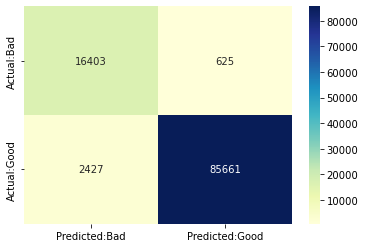

In [33]:
print('Training Accuracy :',lr.score(trainX,trainY))
print('Testing Accuracy :',lr.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(lr.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(lr.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [34]:
mnb = MultinomialNB()

In [35]:
mnb.fit(trainX,trainY)

MultinomialNB()

In [36]:
mnb.score(testX,testY)

0.970651470756117

In [37]:
Scores_ml['MultinomialNB'] = np.round(mnb.score(testX,testY),2)

Training Accuracy : 0.9816868982838007
Testing Accuracy : 0.970651470756117

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.89      0.94      0.92     17695
        Good       0.99      0.98      0.98     87421

    accuracy                           0.97    105116
   macro avg       0.94      0.96      0.95    105116
weighted avg       0.97      0.97      0.97    105116


CONFUSION MATRIX


<AxesSubplot:>

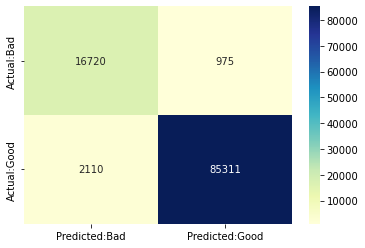

In [38]:
print('Training Accuracy :',mnb.score(trainX,trainY))
print('Testing Accuracy :',mnb.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(mnb.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(mnb.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

<AxesSubplot:ylabel='Accuracy'>

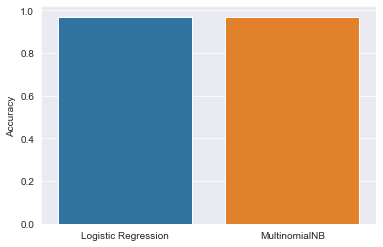

In [39]:
acc = pd.DataFrame.from_dict(Scores_ml,orient = 'index',columns=['Accuracy'])
sns.set_style('darkgrid')
sns.barplot(acc.index,acc.Accuracy)

In [40]:
pipeline_ls = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), LogisticRegression())

In [41]:
trainX, testX, trainY, testY = train_test_split(phish_data.url, phish_data.label)

In [42]:
pipeline_ls.fit(trainX,trainY)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words='english',
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)),
                ('logisticregression', LogisticRegression())])

In [43]:
pipeline_ls.score(testX,testY) 

0.9716598805129572

Training Accuracy : 0.9840335121833657
Testing Accuracy : 0.9716598805129572

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.88      0.96      0.92     17246
        Good       0.99      0.97      0.98     87870

    accuracy                           0.97    105116
   macro avg       0.93      0.97      0.95    105116
weighted avg       0.97      0.97      0.97    105116


CONFUSION MATRIX


<AxesSubplot:>

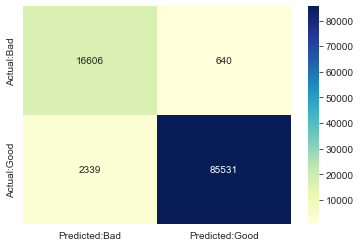

In [44]:
print('Training Accuracy :',pipeline_ls.score(trainX,trainY))
print('Testing Accuracy :',pipeline_ls.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(pipeline_ls.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(pipeline_ls.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [45]:
pickle.dump(pipeline_ls,open('phishing.pkl','wb'))

In [46]:
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
result = loaded_model.score(testX,testY)
print(result)

0.9716598805129572


In [48]:
predict_bad = ['yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php','youtube.com/','fazan-pacir.rs/temp/libraries/ipad','tubemoviez.exe','svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt']
predict_good = ['yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php' , 'youtube.com/','youtube.com/watch?v=qI0TQJI3vdU','retailhellunderground.com/','restorevisioncenters.com/html/technology.html']
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
#predict_bad = vectorizers.transform(predict_bad)
# predict_good = vectorizer.transform(predict_good)
result = loaded_model.predict(predict_bad)
result2 = loaded_model.predict(predict_good)
print(result)
print("*"*30)
print(result2)

['bad' 'good' 'bad' 'bad' 'bad']
******************************
['bad' 'good' 'good' 'good' 'good']
